In [ ]:
!pip install -r requirements.txt

In [ ]:
!playwright install

In [83]:
import subprocess
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from scipy import stats

# Load pantry data

In [37]:
def load_pantry_data():
    pantry_log = pd.read_csv("pantry log.csv")
    pantry_log['snack_name'] = pantry_log['snack_name'].str.lower()
    pantry_log = pantry_log[~pantry_log['empty_date'].isna()]
    return pantry_log

def get_unique_pantry_snacks(pantry_log):
    return list(pantry_log['snack_name'].unique())

In [29]:
pantry_log = load_pantry_data()
snacks_list =  get_unique_pantry_snacks(pantry_log)

# Amazon data scraper

In [13]:
MAX_RESULTS = 10

for snack_name in tqdm(snacks_list):
    # Run the script as a separate Python process
    subprocess.run(["python", "amazon_scraper.py", snack_name, str(MAX_RESULTS)])

100%|██████████| 32/32 [04:03<00:00,  7.60s/it]


In [18]:
def load_and_clean_amazon_data():
    amazon_data = pd.read_csv('amazon_prices.csv')
    amazon_data['price'] = amazon_data['price'].apply(lambda x: float(x.strip('$')))
    return amazon_data
    

In [41]:
amazon_data = load_and_clean_amazon_data()
pantry_log = load_pantry_data()

In [42]:
average_prices = amazon_data.groupby('product_name')['price'].mean().reset_index()
pantry_log = pantry_log.merge(average_prices, how = 'left', left_on = 'snack_name', right_on = 'product_name').drop(columns = ['product_name'])

In [45]:
pantry_log['snack_type'].value_counts()

snack_type
Sweet     25
Savory    24
Name: count, dtype: int64

In [48]:
pantry_log.groupby('snack_type')['days_lasted'].mean()

snack_type
Savory    14.625
Sweet     10.000
Name: days_lasted, dtype: float64

<Axes: xlabel='days_lasted', ylabel='Density'>

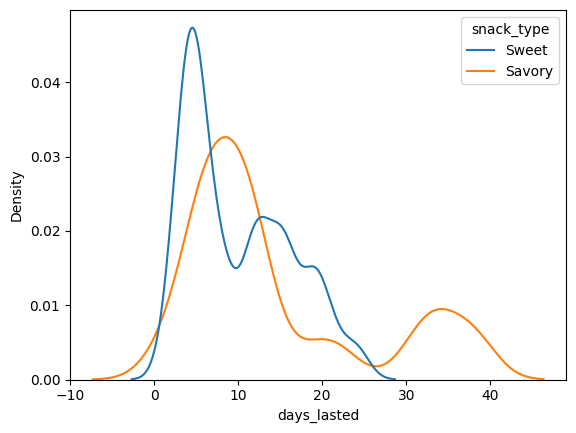

In [82]:
salty_sample = pantry_log[
    pantry_log['snack_type'] == 'Savory'
][['snack_type', 'days_lasted']].sample(n=1000, replace = True)
sweet_sample = pantry_log[
    pantry_log['snack_type'] == 'Sweet'
][['snack_type', 'days_lasted']].sample(n=1000, replace = True)
sns.kdeplot(
    pd.concat([sweet_sample, salty_sample]),
    x = 'days_lasted',
    hue = 'snack_type',
    multiple = 'layer'
)

In [84]:
stats.kstest(salty_sample['days_lasted'].values, sweet_sample['days_lasted'].values)

KstestResult(statistic=0.283, pvalue=1.1405545071561369e-35, statistic_location=5, statistic_sign=-1)